
# Speech Recognition with Wav2Vec2

**Author**: [Moto Hira](moto@meta.com)_

This tutorial shows how to perform speech recognition using using
pre-trained models from wav2vec 2.0
[[paper](https://arxiv.org/abs/2006.11477)_].


## Overview

The process of speech recognition looks like the following.

1. Extract the acoustic features from audio waveform

2. Estimate the class of the acoustic features frame-by-frame

3. Generate hypothesis from the sequence of the class probabilities

Torchaudio provides easy access to the pre-trained weights and
associated information, such as the expected sample rate and class
labels. They are bundled together and available under
:py:mod:`torchaudio.pipelines` module.




## Preparation




In [1]:
import torch
import torchaudio

print(torch.__version__)
print(torchaudio.__version__)

torch.random.manual_seed(0)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(device)

1.12.1+cu113
0.12.1+cu113
cpu


In [2]:
import IPython
import matplotlib.pyplot as plt
from torchaudio.utils import download_asset

SPEECH_FILE = download_asset("tutorial-assets/Lab41-SRI-VOiCES-src-sp0307-ch127535-sg0042.wav")

  0%|          | 0.00/106k [00:00<?, ?B/s]

## Creating a pipeline

First, we will create a Wav2Vec2 model that performs the feature
extraction and the classification.

There are two types of Wav2Vec2 pre-trained weights available in
torchaudio. The ones fine-tuned for ASR task, and the ones not
fine-tuned.

Wav2Vec2 (and HuBERT) models are trained in self-supervised manner. They
are firstly trained with audio only for representation learning, then
fine-tuned for a specific task with additional labels.

The pre-trained weights without fine-tuning can be fine-tuned
for other downstream tasks as well, but this tutorial does not
cover that.

We will use :py:data:`torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H` here.

There are multiple pre-trained models available in :py:mod:`torchaudio.pipelines`.
Please check the documentation for the detail of how they are trained.

The bundle object provides the interface to instantiate model and other
information. Sampling rate and the class labels are found as follow.




In [3]:
bundle = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H

print("Sample Rate:", bundle.sample_rate)

print("Labels:", bundle.get_labels())

Sample Rate: 16000
Labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


Model can be constructed as following. This process will automatically
fetch the pre-trained weights and load it into the model.




In [4]:
model = bundle.get_model().to(device)

print(model.__class__)

Downloading: "https://download.pytorch.org/torchaudio/models/wav2vec2_fairseq_base_ls960_asr_ls960.pth" to /root/.cache/torch/hub/checkpoints/wav2vec2_fairseq_base_ls960_asr_ls960.pth


  0%|          | 0.00/360M [00:00<?, ?B/s]

<class 'torchaudio.models.wav2vec2.model.Wav2Vec2Model'>


## Loading data

We will use the speech data from [VOiCES
dataset](https://iqtlabs.github.io/voices/)_, which is licensed under
Creative Commos BY 4.0.




In [5]:
IPython.display.Audio(SPEECH_FILE)

To load data, we use :py:func:`torchaudio.load`.

If the sampling rate is different from what the pipeline expects, then
we can use :py:func:`torchaudio.functional.resample` for resampling.

<div class="alert alert-info"><h4>Note</h4><p>- :py:func:`torchaudio.functional.resample` works on CUDA tensors as well.
   - When performing resampling multiple times on the same set of sample rates,
     using :py:class:`torchaudio.transforms.Resample` might improve the performace.</p></div>




In [6]:
waveform, sample_rate = torchaudio.load(SPEECH_FILE)
waveform = waveform.to(device)

if sample_rate != bundle.sample_rate:
    waveform = torchaudio.functional.resample(waveform, sample_rate, bundle.sample_rate)

## Extracting acoustic features

The next step is to extract acoustic features from the audio.

<div class="alert alert-info"><h4>Note</h4><p>Wav2Vec2 models fine-tuned for ASR task can perform feature
   extraction and classification with one step, but for the sake of the
   tutorial, we also show how to perform feature extraction here.</p></div>




In [7]:
with torch.inference_mode():
    features, _ = model.extract_features(waveform)

The returned features is a list of tensors. Each tensor is the output of
a transformer layer.




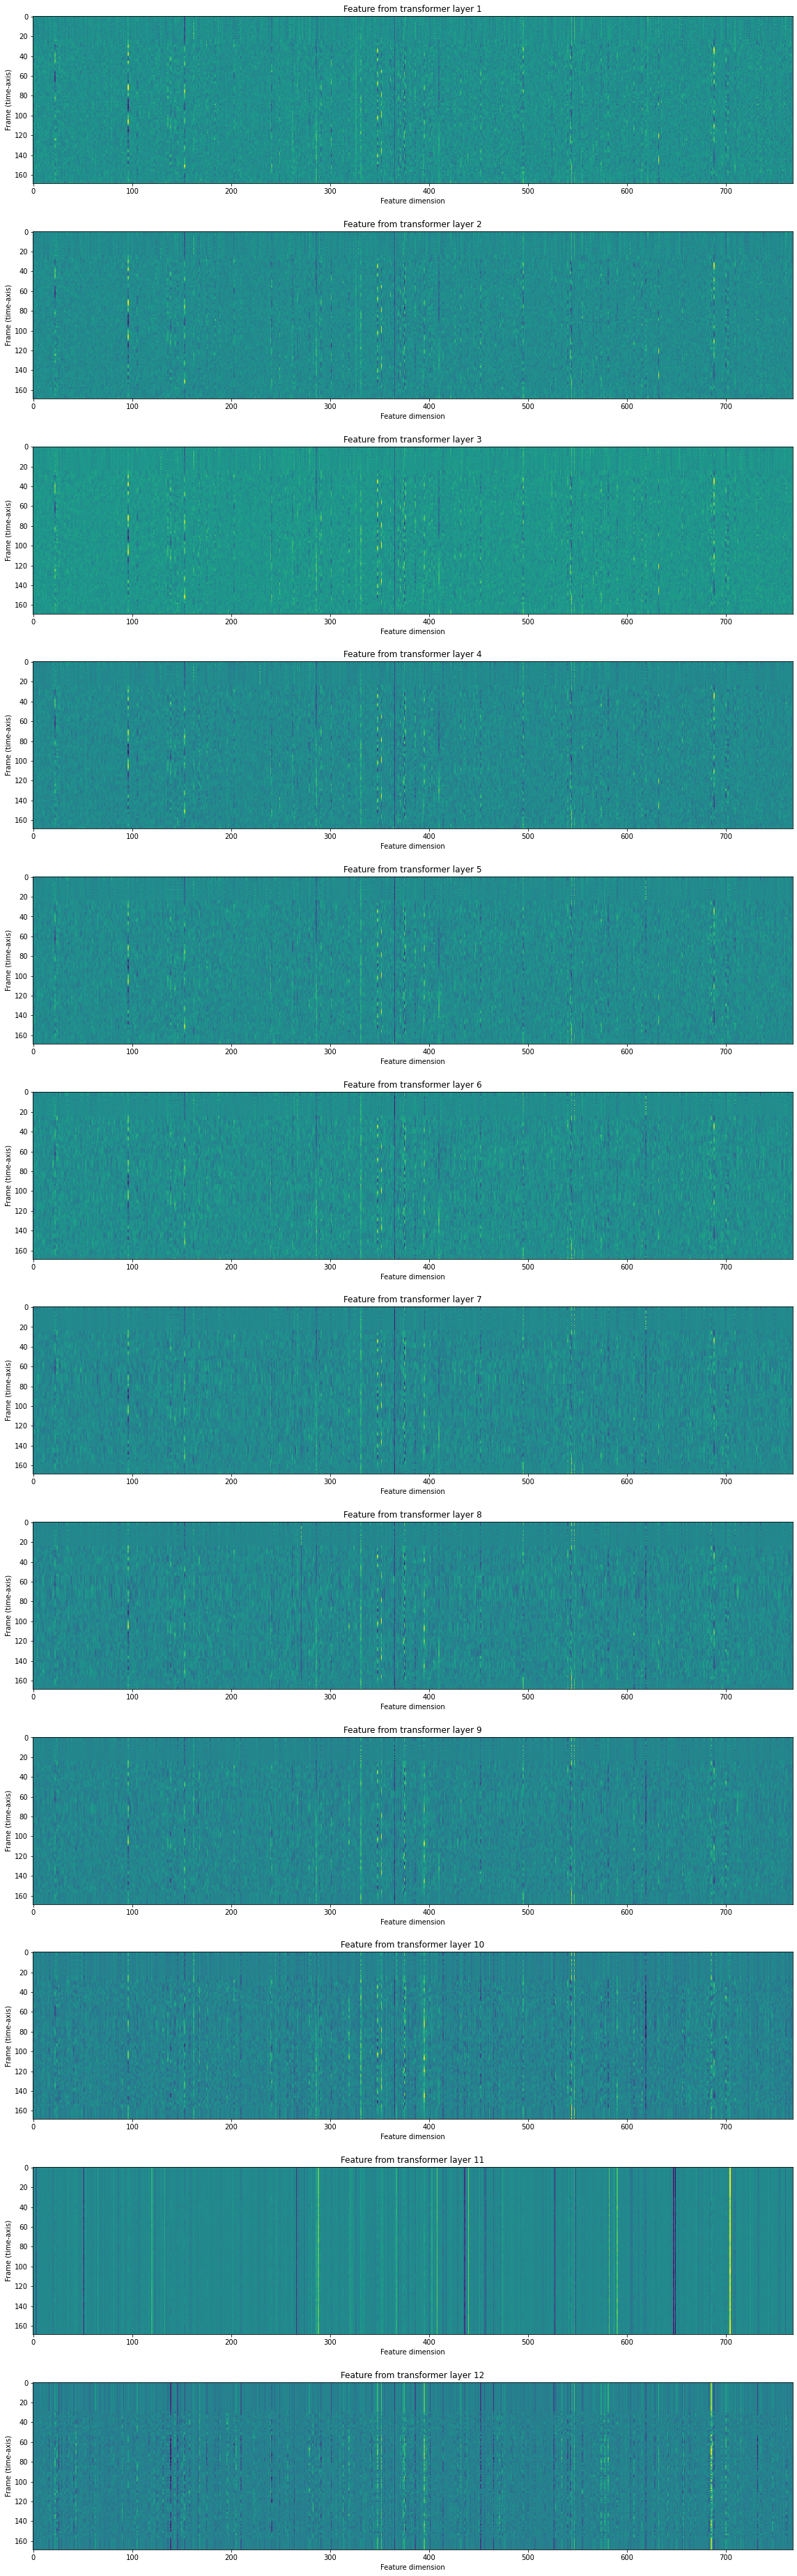

In [8]:
fig, ax = plt.subplots(len(features), 1, figsize=(16, 4.3 * len(features)))
for i, feats in enumerate(features):
    ax[i].imshow(feats[0].cpu(), interpolation="nearest")
    ax[i].set_title(f"Feature from transformer layer {i+1}")
    ax[i].set_xlabel("Feature dimension")
    ax[i].set_ylabel("Frame (time-axis)")
plt.tight_layout()
plt.show()

## Feature classification

Once the acoustic features are extracted, the next step is to classify
them into a set of categories.

Wav2Vec2 model provides method to perform the feature extraction and
classification in one step.




In [9]:
with torch.inference_mode():
    emission, _ = model(waveform)

The output is in the form of logits. It is not in the form of
probability.

Let’s visualize this.




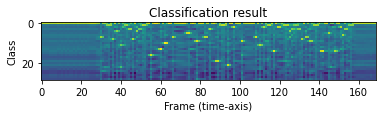

Class labels: ('-', '|', 'E', 'T', 'A', 'O', 'N', 'I', 'H', 'S', 'R', 'D', 'L', 'U', 'M', 'W', 'C', 'F', 'G', 'Y', 'P', 'B', 'V', 'K', "'", 'X', 'J', 'Q', 'Z')


In [10]:
plt.imshow(emission[0].cpu().T, interpolation="nearest")
plt.title("Classification result")
plt.xlabel("Frame (time-axis)")
plt.ylabel("Class")
plt.show()
print("Class labels:", bundle.get_labels())

We can see that there are strong indications to certain labels across
the time line.




## Generating transcripts

From the sequence of label probabilities, now we want to generate
transcripts. The process to generate hypotheses is often called
“decoding”.

Decoding is more elaborate than simple classification because
decoding at certain time step can be affected by surrounding
observations.

For example, take a word like ``night`` and ``knight``. Even if their
prior probability distribution are differnt (in typical conversations,
``night`` would occur way more often than ``knight``), to accurately
generate transcripts with ``knight``, such as ``a knight with a sword``,
the decoding process has to postpone the final decision until it sees
enough context.

There are many decoding techniques proposed, and they require external
resources, such as word dictionary and language models.

In this tutorial, for the sake of simplicity, we will perform greedy
decoding which does not depend on such external components, and simply
pick up the best hypothesis at each time step. Therefore, the context
information are not used, and only one transcript can be generated.

We start by defining greedy decoding algorithm.




In [11]:
class GreedyCTCDecoder(torch.nn.Module):
    def __init__(self, labels, blank=0):
        super().__init__()
        self.labels = labels
        self.blank = blank

    def forward(self, emission: torch.Tensor) -> str:
        """Given a sequence emission over labels, get the best path string
        Args:
          emission (Tensor): Logit tensors. Shape `[num_seq, num_label]`.

        Returns:
          str: The resulting transcript
        """
        indices = torch.argmax(emission, dim=-1)  # [num_seq,]
        indices = torch.unique_consecutive(indices, dim=-1)
        indices = [i for i in indices if i != self.blank]
        return "".join([self.labels[i] for i in indices])

Now create the decoder object and decode the transcript.




In [12]:
decoder = GreedyCTCDecoder(labels=bundle.get_labels())
transcript = decoder(emission[0])

Let’s check the result and listen again to the audio.




In [13]:
print(transcript)
IPython.display.Audio(SPEECH_FILE)

I|HAD|THAT|CURIOSITY|BESIDE|ME|AT|THIS|MOMENT|


The ASR model is fine-tuned using a loss function called Connectionist Temporal Classification (CTC).
The detail of CTC loss is explained
[here](https://distill.pub/2017/ctc/)_. In CTC a blank token (ϵ) is a
special token which represents a repetition of the previous symbol. In
decoding, these are simply ignored.




## Conclusion

In this tutorial, we looked at how to use :py:class:`~torchaudio.pipelines.Wav2Vec2ASRBundle` to
perform acoustic feature extraction and speech recognition. Constructing
a model and getting the emission is as short as two lines.

::

   model = torchaudio.pipelines.WAV2VEC2_ASR_BASE_960H.get_model()
   emission = model(waveforms, ...)


